# Final Project by Edoardo & Anna

## Estimation of $H_0$, $\Omega_m$ and $w_{\Lambda}$ using DESI 2024 data

In [1]:
import sys
sys.path.append("/mnt/c/Users/dambr/Desktop/AstroCosmoComputational/Students/Anna_DAmbrosio/")

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",})

from pyACC.Calculus import *

from pyACC.cosmology import *

from pyACC.clustering import *

import scipy as sp
from scipy import interpolate
from scipy.misc import derivative

from inspect import signature 

from random import randint

import corner
import pygtc
import getdist
from getdist import plots

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

### DESI cosmology

In [2]:
# DESI cosmology

O_m_DESI = 0.295
w_de_DESI = -0.99
H_0_DESI = 68.52

### DESI data extraction

In [3]:
# reading of the data and their management through the class dataDESImanager

data = open('DESIdata.txt', 'r')
lines = data.readlines()
lines = np.array(lines)
n = lines.size
DATA = np.zeros((n, n))
DATA = np.loadtxt("DESIdata.txt")

dataDESI, covDESI = dataDESImanager(DATA)

deltaDESI = np.sqrt(np.diag(covDESI))

z_DESI = dataDESI[:,0]
DV_DESI = dataDESI[:,1]

### PART 1: Test with fake data from a known cosmology

$\textbf{C1 cosmology}$: \
$H_0 = 68.52$ \
$\Omega_m = 0.295$ \
$\Omega_{\gamma} = 0.0$ \
$\Omega_{\nu} = 0.0$ \
$\Omega_{\Lambda} = 0.705$ \
$w_{\Lambda} = -0.99$

In [4]:
# definition of the cosmology

O_m_C1 = O_m_DESI
w_de_C1 = w_de_DESI
H_0_C1 = H_0_DESI

In [5]:
# generation of fake data given a gaussian with mean the value calculated with the given codmology and error taken from DESI data

mean_DV_C1 = distance_volume_over_rd(z=z_DESI, H_0=H_0_C1, O_m=O_m_C1, O_gam=0, O_nu=0, O_de=(1-O_m_C1), w_de=w_de_C1, w0=0, wa=0)

data_C1 = np.random.normal(mean_DV_C1, deltaDESI)

In [6]:
# creation of data set with DESI format

zero_column = np.zeros(z_DESI.size)

DATA_C1 = np.column_stack([z_DESI, zero_column, zero_column, zero_column, zero_column, data_C1, deltaDESI])

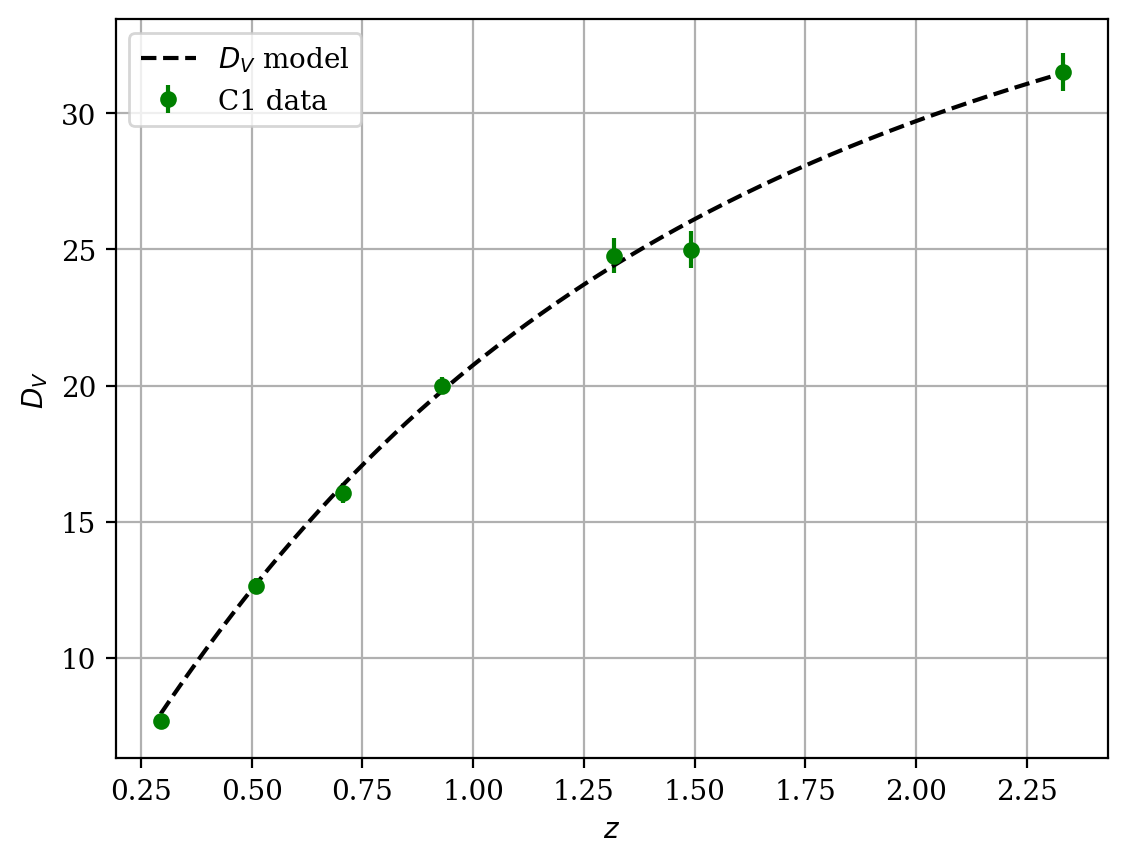

In [7]:
# plot of the data

fig, ax = plt.subplots()
ax.errorbar(DATA_C1[:,0], DATA_C1[:,5], yerr=DATA_C1[:,6], fmt='o', ms=5, label='C1 data',color='green')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$D_V$')

z_array = np.linspace(z_DESI[0], z_DESI[-1], 1000)
D_V_th = distance_volume_over_rd(z_array, H_0=H_0_C1, O_m=O_m_C1, O_gam=0, O_nu=0, O_de=(1-O_m_C1), w_de=w_de_C1, w0=0, wa=0)
ax.plot(z_array, D_V_th, label=r'$D_V$ model', ls='--', color='black')

ax.grid()
ax.legend()

In [8]:
# definition of function that describes the data

func_dist = lambda z,Om,wde,H0:distance_volume_over_rd(z, H_0=H0, O_m=Om, O_gam=0, O_nu=0, O_de=(1-Om), w_de=wde, w0=0, wa=0)

In [9]:
# calculation of logLikelihood with flat priors

infs = np.array([0.01, -3.0, 30.0])
sups = np.array([0.99, -0.5, 100.0])
LogL_C1 = logL_flatPrior(DATA_C1, func_dist = func_dist, infs=infs, sups=sups)

Arguments of LH:  ['Om', 'wde', 'H0']


In [10]:
# sampling with MCMC

Om_point = O_m_C1
wde_point = w_de_C1
H0_point = H_0_C1
point0 = np.array([Om_point,wde_point,H0_point])
ds=np.array([0.01,0.01,0.01])
covmat = np.diag(ds**2)
N = 100000

results_C1, eff_results_C1 = sampler.Metropolis_Hastings(LogL_C1, x0=point0, N=N, cov=covmat, type='gaussian', log=True)

Metropolis-Hastings (gaussian): 100%|██████████| 100000/100000 [03:09<00:00, 528.43it/s]


Removed no burn in


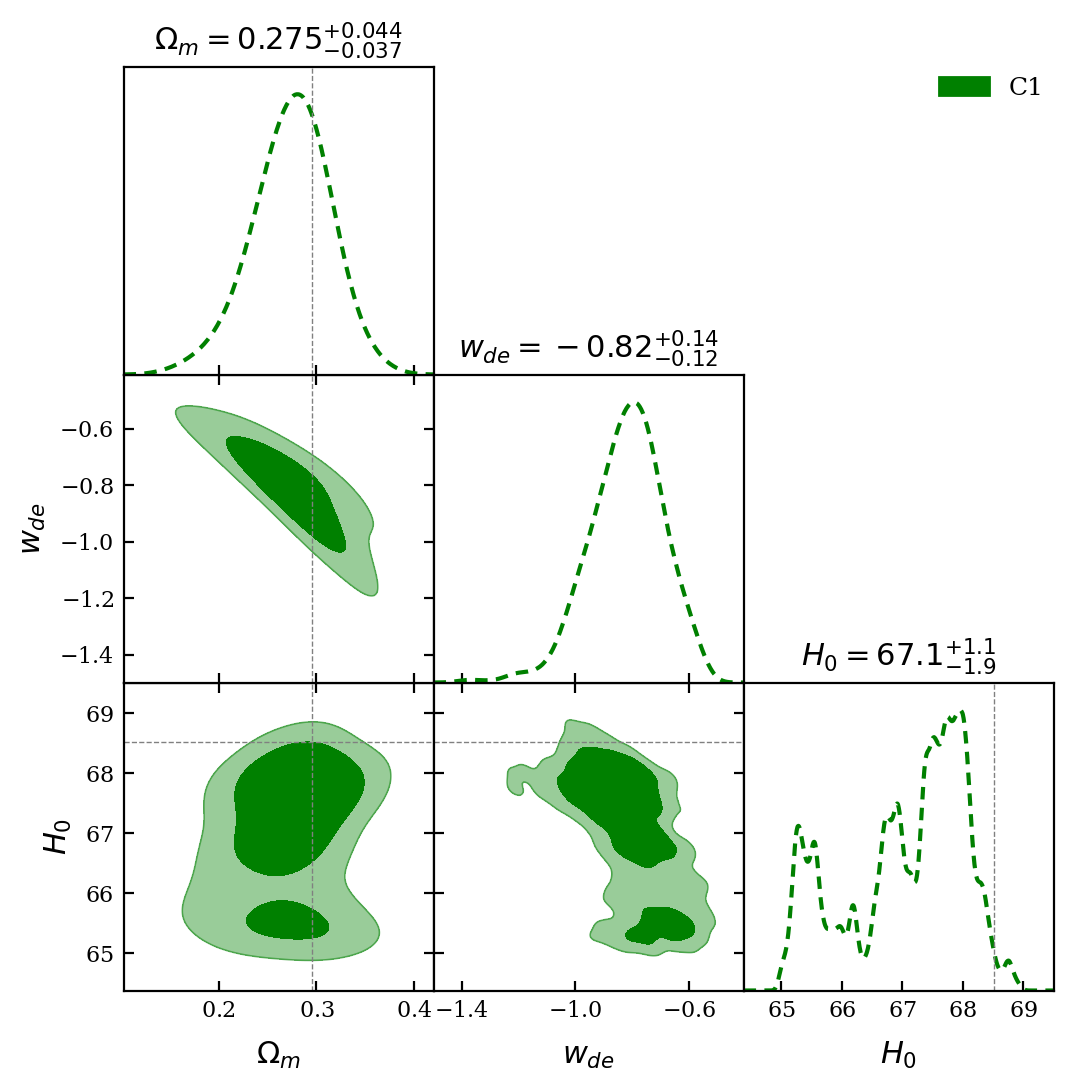

In [11]:
# corner plot

Om_sample_C1 = results_C1[:,0]
wde_sample_C1 = results_C1[:,1]
H0_sample_C1 = results_C1[:,2]

names = ["\Omega_m","w_{de}","H_0"]
labels = ["\Omega_m","w_{de}", "H_0"]

samples_C1 = getdist.mcsamples.MCSamples(samples=results_C1,names = names, labels = labels, label='Flat proposal')

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter(subplot_size=2)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14

g.triangle_plot(samples_C1, legend_labels=['C1'], 
                filled=True,
                line_args={'ls':'--','lw':1.5, 'color':'green'},
                contour_colors=['green'], 
                legend_loc='upper right',
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'\Omega_m':O_m_C1, 'w_{DE}':w_de_C1, 'H_0':H_0_C1})

### PART 2: Test with DESI data

$\textbf{DESI cosmology}$: \
$H_0 = 68.52$ \
$\Omega_m = 0.295$ \
$\Omega_{\gamma} = 0.0$ \
$\Omega_{\nu} = 0.0$ \
$\Omega_{\Lambda} = 0.705$ \
$w_{\Lambda} = -0.99$

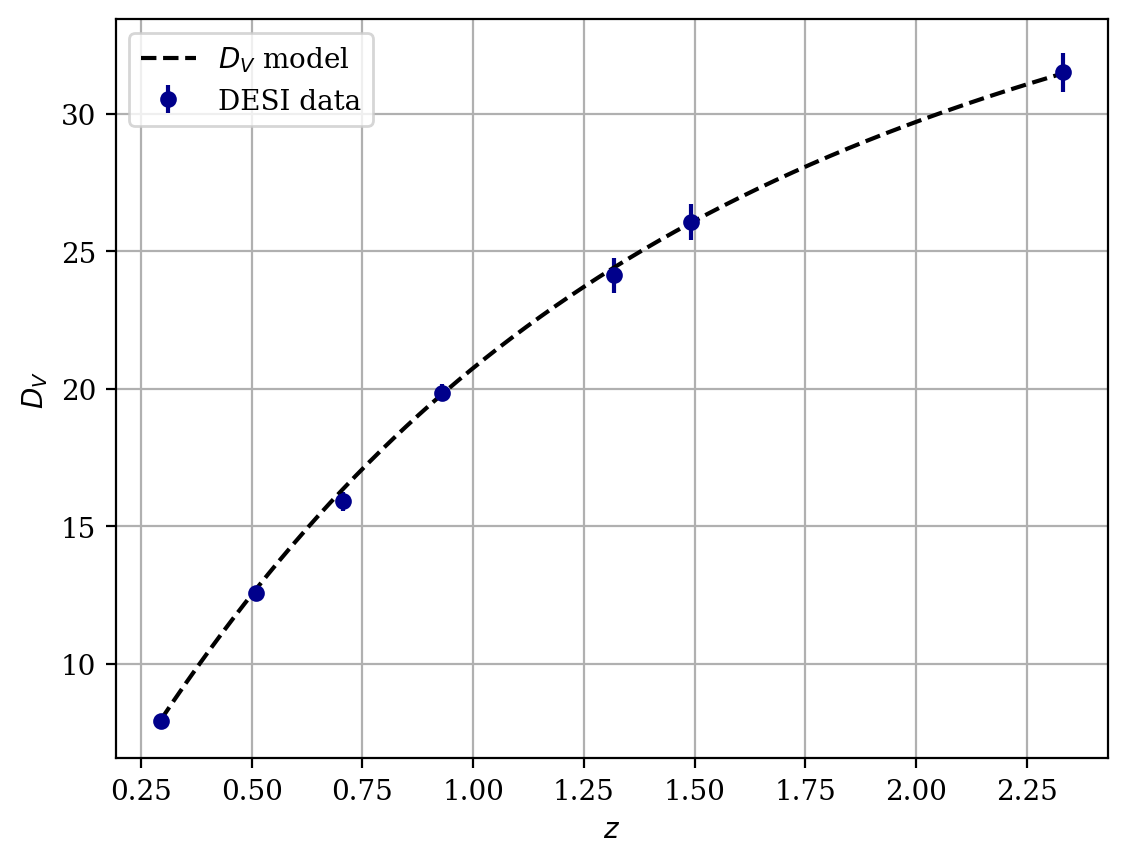

In [12]:
# plot of the data

fig, ax = plt.subplots()
ax.errorbar(z_DESI, DV_DESI, deltaDESI, fmt='o', ms=5, label='DESI data',color='darkblue')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$D_V$')

z_array = np.linspace(z_DESI[0], z_DESI[-1], 1000)
D_V_th = distance_volume_over_rd(z_array, H_0=H_0_DESI, O_m=O_m_DESI, O_gam=0, O_nu=0, O_de=(1-O_m_DESI), w_de=w_de_DESI, w0=0, wa=0)
ax.plot(z_array, D_V_th, label=r'$D_V$ model', ls='--', color='black')

ax.grid()
ax.legend()

In [13]:
# definition of function that describes the data

func_dist_DESI = lambda z,Om,wde,H0:distance_volume_over_rd(z, H_0=H0, O_m=Om, O_gam=0, O_nu=0, O_de=(1-Om), w_de=wde, w0=0, wa=0)

In [14]:
# calculation of logLikelihood with flat priors

infs = np.array([0.01, -3.0, 30.0])
sups = np.array([0.99, -0.5, 100.0])
LogL_DESI = logL_flatPrior(DATA, func_dist = func_dist_DESI, infs=infs, sups=sups)

Arguments of LH:  ['Om', 'wde', 'H0']


In [15]:
# sampling with MCMC

Om_point_DESI = O_m_DESI
wde_point_DESI = w_de_DESI
H0_point_DESI = H_0_DESI
point0_DESI = np.array([Om_point_DESI,wde_point_DESI,H0_point_DESI])
ds=np.array([0.01,0.01,0.01])
covmat = np.diag(ds**2)
N_DESI = 100000

results_DESI, eff_results_DESI = sampler.Metropolis_Hastings(LogL_DESI, x0=point0_DESI, N=N_DESI, cov=covmat, type='gaussian', log=True)

Metropolis-Hastings (gaussian): 100%|██████████| 100000/100000 [03:07<00:00, 534.64it/s]


Removed no burn in


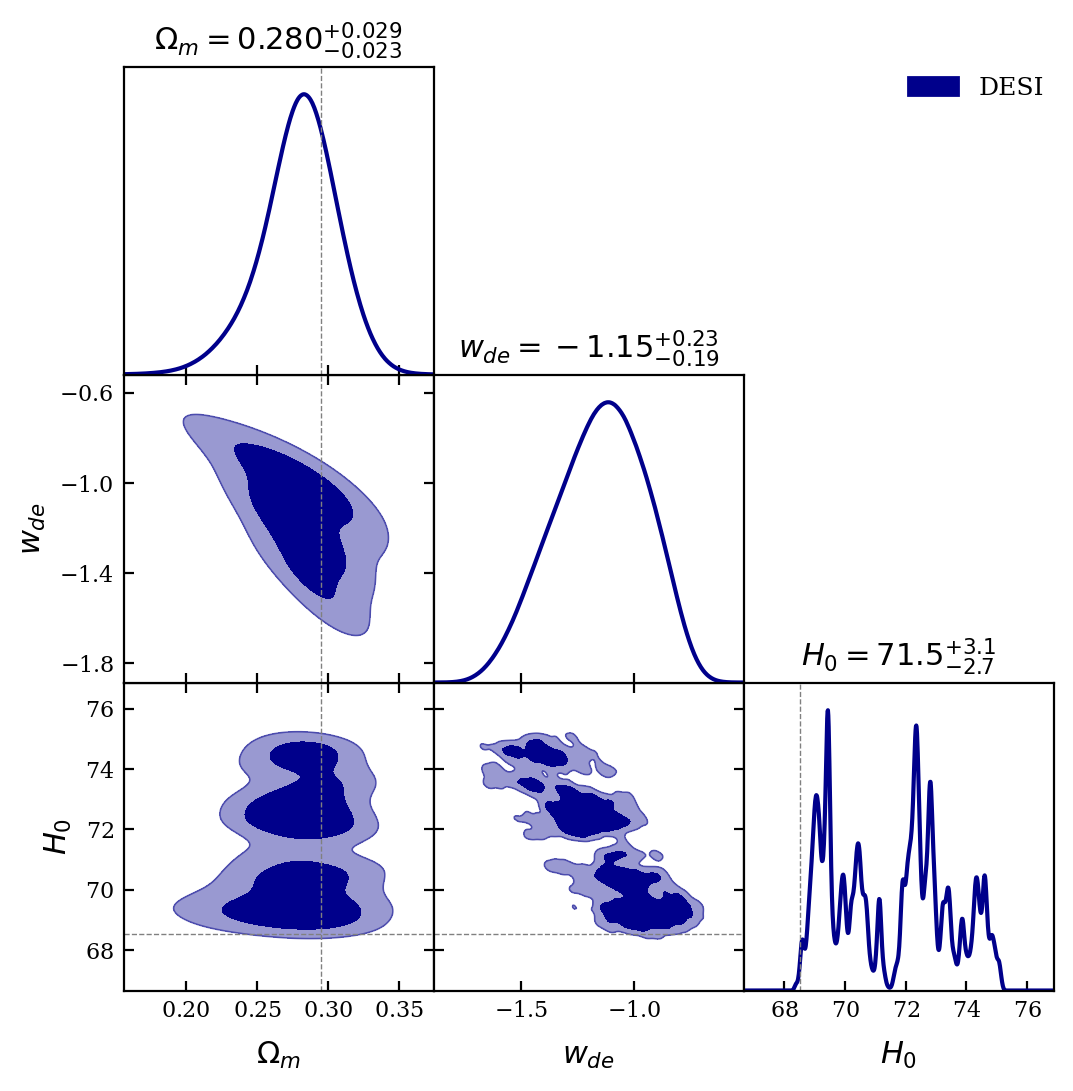

In [16]:
# corner plot

Om_sample_DESI = results_DESI[:,0]
wde_sample_DESI = results_DESI[:,1]
H0_sample_DESI = results_DESI[:,2]

names = ["\Omega_m","w_{de}", "H_0"]
labels = ["\Omega_m","w_{de}", "H_0"]

samples_DESI = getdist.mcsamples.MCSamples(samples=results_DESI,names = names, labels = labels, label='Flat proposal')

g = plots.get_subplot_plotter(subplot_size=2)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14

g.triangle_plot(samples_DESI, legend_labels=['DESI'],
                filled=True,
                line_args={'lw':1.5, 'color':'darkblue'},
                contour_colors=['darkblue'], 
                legend_loc='upper right',
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'\Omega_m':O_m_DESI, 'w_{DE}':w_de_DESI,'H_0':H_0_DESI})

### PART 3: Confronting DESI and C1 results

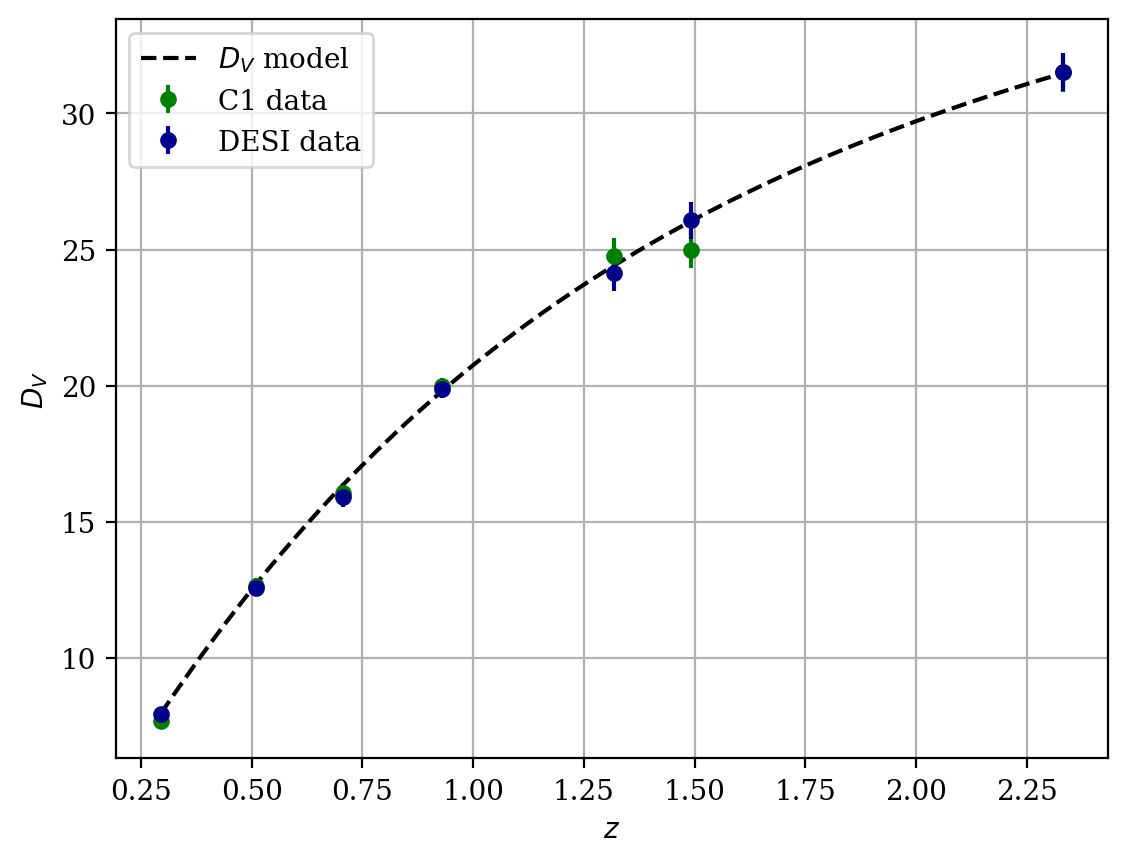

In [17]:
# data points

fig, ax = plt.subplots()
ax.errorbar(DATA_C1[:,0], DATA_C1[:,5], yerr=DATA_C1[:,6], fmt='o', ms=5, label='C1 data', color='green')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$D_V$')
ax.errorbar(z_DESI, DV_DESI, deltaDESI, fmt='o', ms=5, label='DESI data', color='darkblue')

z_array = np.linspace(z_DESI[0], z_DESI[-1], 1000)
D_V_th = distance_volume_over_rd(z_array, H_0=H_0_DESI, O_m=O_m_DESI, O_gam=0, O_nu=0, O_de=(1-O_m_DESI), w_de=w_de_DESI, w0=0, wa=0)
ax.plot(z_array, D_V_th, label=r'$D_V$ model', ls='--', color='black')
ax.grid()
ax.legend()

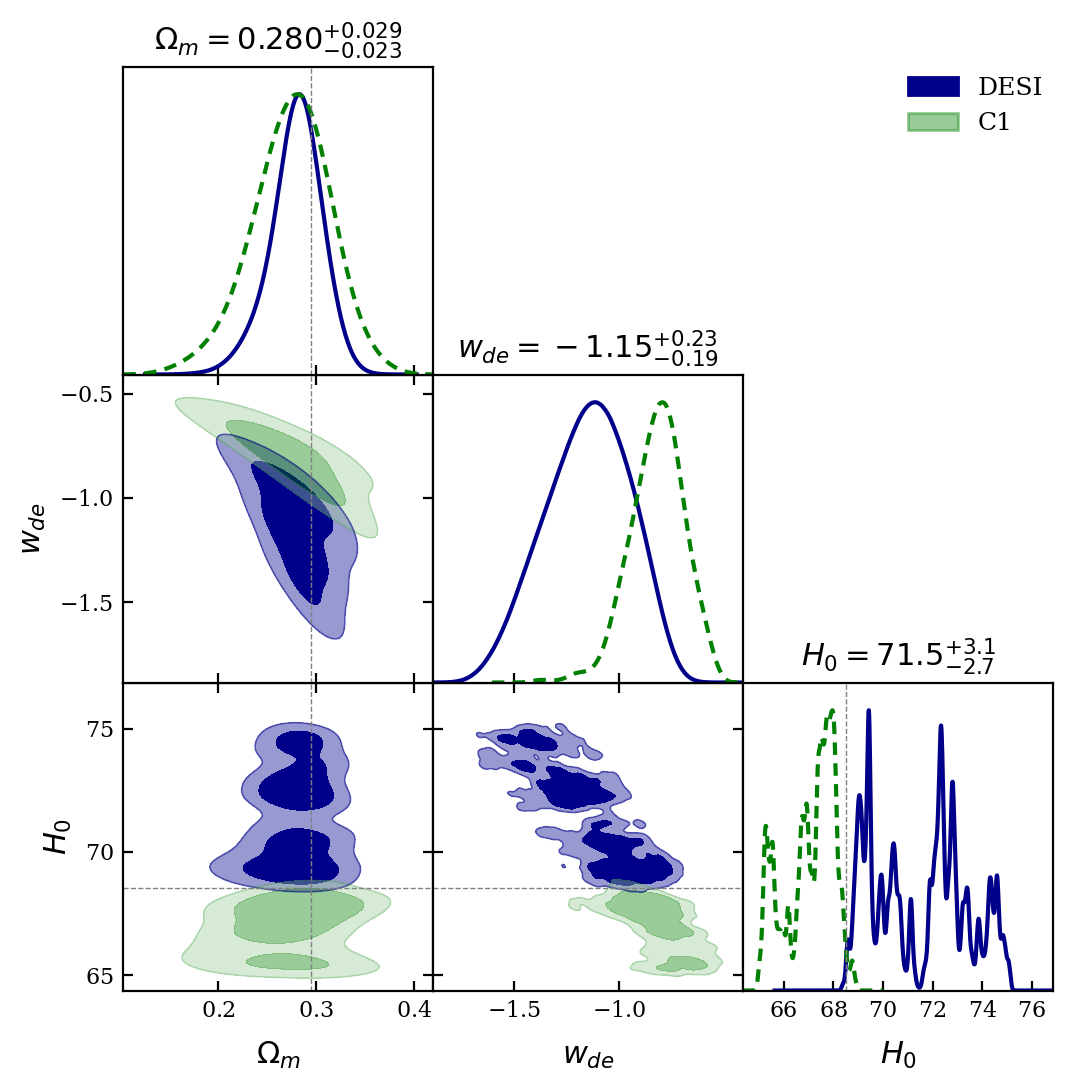

In [18]:
# corner plot

g = plots.get_subplot_plotter(subplot_size=2)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14


g.triangle_plot([samples_DESI,samples_C1], legend_labels=['DESI','C1'],
                filled=True,
                legend_loc='upper right',
                line_args=[{'lw':1.5, 'color':'darkblue'},
                           {'ls':'--','lw':1.5, 'color':'green'}], 
                contour_colors=['darkblue','green'],
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'\Omega_m':O_m_DESI, 'w_{DE}':w_de_DESI, 'H_0':H_0_DESI},)